<a href="https://colab.research.google.com/github/bakarin/DogBreed-Image-Classifier/blob/master/DogBreed_Classifier_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification with Transfer Learning in TensorFlow


## Imports

In [1]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
import numpy as np
import cv2                
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

## Helpers

Load the following helper functions via the  `deeplearning2020` python package:

- def plot_learning_curve(title, x, y, y_test, ylim=0.6)
- def plot_history(title, history, ylim=0.6)
- def plot_images(images, labels)

helper functions [source](https://github.com/into-ai/deeplearning2020/blob/master/deeplearning2020/helpers.py)

In [3]:
!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

     |████████████████████████████████| 399kB 3.9MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=351faf158494a70814b6f20f72690c9e165f374963360c383b21a51587ec6c51
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=97ae895cebc87cd2cb67bb6b494e7f0993715f754bcc4bad89daf71bdc58c8d5
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission


## Load Dataset

Imagewoof is a subset of 10 classes from Imagenet that are all dog breeds. The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog.

In [4]:
from deeplearning2020.datasets import ImageWoof
train_data_raw, test_data_raw, classes = ImageWoof.load_data()

328294400/328288506 [==============================] - 5s 0us/step
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


In [5]:
# number of classes
classes.shape

(10,)

In [6]:
# classes
n_classes = classes.shape[0]
print(classes)

['Shih-Tzu' 'Rhodesian ridgeback' 'Beagle' 'English foxhound'
 'Border terrier' 'Australian terrier' 'Golden retriever'
 'Old English sheepdog' 'Samoyed' 'Dingo']


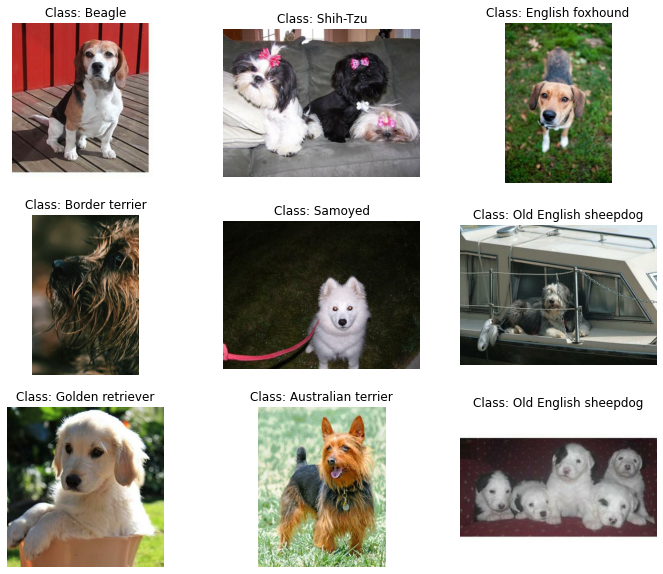

In [7]:
# display 9 sample images from the train set
helpers.plot_images(train_data_raw.take(9), classes)

In [8]:
# check the array of one training data sample
for image, label in train_data_raw.take(1): 
    print(image.numpy())

[[[0.10588236 0.14901961 0.1254902 ]
  [0.01568628 0.05882353 0.03529412]
  [0.00784314 0.0509804  0.02745098]
  ...
  [0.05490196 0.08235294 0.05490196]
  [0.05882353 0.08627451 0.05882353]
  [0.05882353 0.08627451 0.05882353]]

 [[0.1137255  0.15686275 0.13333334]
  [0.0627451  0.10588236 0.08235294]
  [0.03137255 0.07450981 0.0509804 ]
  ...
  [0.0627451  0.09019608 0.0627451 ]
  [0.07058824 0.09803922 0.07058824]
  [0.07058824 0.09803922 0.07058824]]

 [[0.12156864 0.16470589 0.14117648]
  [0.1137255  0.15686275 0.13333334]
  [0.06666667 0.10980393 0.08627451]
  ...
  [0.06666667 0.09411766 0.06666667]
  [0.05882353 0.08627451 0.05882353]
  [0.05882353 0.08627451 0.05882353]]

 ...

 [[0.24705884 0.37254903 0.52156866]
  [0.2392157  0.3647059  0.5137255 ]
  [0.19215688 0.31764707 0.4666667 ]
  ...
  [0.25882354 0.37254903 0.5058824 ]
  [0.25882354 0.37254903 0.5058824 ]
  [0.25490198 0.36862746 0.5019608 ]]

 [[0.2392157  0.3647059  0.5137255 ]
  [0.21176472 0.3372549  0.48627454]


## Preprocessing
 Resize all images to 299 x 299 pixels and run them through Xception's preprocessing function. We are normalizing them from their original range from 0 to 1 to 0 to 255 as this is the required input format for Xception.


In [0]:

def preprocess(image, label='default'):
  '''standard preprocessing function'''
  # resize the images to a uniform size
  resized_image = tf.image.resize(image*255, [224, 224])
  
  # run Xceptions preprocessing function
  preprocessed_image = tf.keras.applications.xception.preprocess_input(resized_image)
  
  return preprocessed_image, label


def preprocess_with_data_augmentation(image, label):
  '''alternative preprocessing function with data augmentation'''
  # resize the images to a uniform size
  resized_image = tf.image.resize(image*255, [224, 224])

  # data augmentation with Tensorflow
  augmented_image = tf.image.random_flip_left_right(resized_image)
  #augmented_image = tf.image.random_hue(augmented_image, 0.08)
  #augmented_image = tf.image.random_saturation(augmented_image, 0.6, 1.6)
  #augmented_image = tf.image.random_brightness(augmented_image, 0.05)
  #augmented_image = tf.image.random_contrast(augmented_image, 0.7, 1.3)

  # run Xceptions preprocessing function
  preprocessed_image = tf.keras.applications.xception.preprocess_input(augmented_image)
  
  return preprocessed_image, label

Apply `preprocess` function to all data

`.batch` prepares the next batch of the specified batch_size

`.prefetch` loads the next batch into memory


In [10]:
batch_size = 32 
train_data = train_data_raw.shuffle(1000) 
print('train_data shape before preprocessing: ', train_data)
# data augmentation on train data
train_data = train_data_raw.map(preprocess_with_data_augmentation).batch(batch_size).prefetch(1)          
print('train_data shape after preprocessing: ', train_data)

# no data augmentation on test data
test_data = test_data_raw.map(preprocess).batch(batch_size).prefetch(1)


train_data shape before preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
train_data shape after preprocessing:  <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


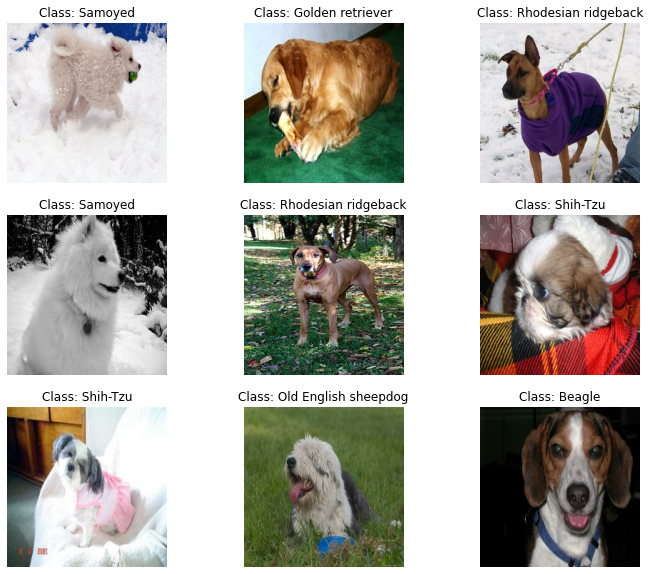

In [11]:
# display 9 sample images from the train set after pre-processing
# to avoid clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)
# we shift the values from -1..1 to 0..1 with a mapping function
helpers.plot_images(train_data.unbatch().take(9).map(lambda x, y: ((x+1)/2, y)), classes)

## Model Definition

- Use a pretrained Xception model without its original classifier
- make a new fully-connected classifier with the correct number of classes for our case and dense_neurons=1000
- include 50 % dropout 
- Output Function with `softmax` activation



In [12]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
# by setting include_top to False to remove original classifier and defining a new output_layer
base_model = Xception(weights='imagenet',
                      include_top=False)

model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
# uncomment for a look at the model architecture
# model.summary()

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model.layers:
  layer.trainable = False

In [0]:
#model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Model Training

In [16]:
history = model.fit(train_data,
                    epochs=5,
                    validation_data=test_data)

Epoch 1/5
283/283 [==============================] - 32s 112ms/step - loss: 1.1291 - accuracy: 0.7064 - val_loss: 0.4459 - val_accuracy: 0.9262
Epoch 2/5
283/283 [==============================] - 31s 108ms/step - loss: 0.3710 - accuracy: 0.9198 - val_loss: 0.2753 - val_accuracy: 0.9348
Epoch 3/5
283/283 [==============================] - 31s 108ms/step - loss: 0.2695 - accuracy: 0.9327 - val_loss: 0.2295 - val_accuracy: 0.9364
Epoch 4/5
283/283 [==============================] - 31s 108ms/step - loss: 0.2361 - accuracy: 0.9372 - val_loss: 0.2097 - val_accuracy: 0.9356
Epoch 5/5
283/283 [==============================] - 31s 108ms/step - loss: 0.2084 - accuracy: 0.9381 - val_loss: 0.1990 - val_accuracy: 0.9369


## Model Performance Evaluation

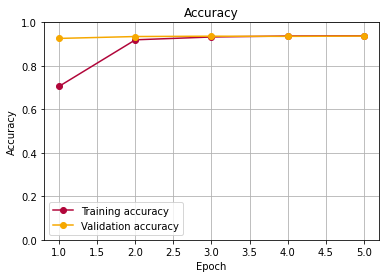

In [17]:
helpers.plot_history('Accuracy', history, 0)

In [18]:
eval_loss, eval_accuracy = model.evaluate(test_data, verbose=False)
print("Model accuracy: %.2f" % eval_accuracy)

Model accuracy: 0.94


## Model Finetuning

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [0]:
# to finetune the model, we have to set more layers (but perhaps not all)
# to trainable and reduce the learning rate drastically
# to prevent destroying of weights
# we choose to unfreeze the last 2 only
for layer in base_model.layers[-2:]:
  layer.trainable = True

In [21]:
# reduce the learning rate to not damage the pretrained weights
# model will need longer to train because more layers are trainable
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune=model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
283/283 [==============================] - 31s 111ms/step - loss: 0.2200 - accuracy: 0.9413 - val_loss: 0.1818 - val_accuracy: 0.9394
Epoch 2/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1787 - accuracy: 0.9456 - val_loss: 0.1780 - val_accuracy: 0.9399
Epoch 3/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1661 - accuracy: 0.9478 - val_loss: 0.1743 - val_accuracy: 0.9412
Epoch 4/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1631 - accuracy: 0.9496 - val_loss: 0.1777 - val_accuracy: 0.9425
Epoch 5/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1533 - accuracy: 0.9528 - val_loss: 0.1736 - val_accuracy: 0.9407
Epoch 6/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1538 - accuracy: 0.9512 - val_loss: 0.1749 - val_accuracy: 0.9417
Epoch 7/10
283/283 [==============================] - 31s 108ms/step - loss: 0.1489 - accuracy: 0.9504 - val_loss: 0.1727 - val_ac

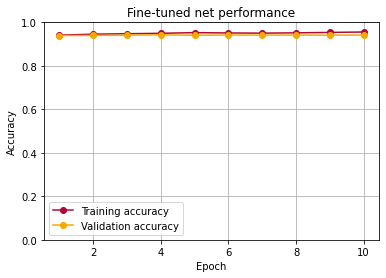

In [22]:
helpers.plot_history('Fine-tuned net performance', history_finetune, 0)

## Model Inference (Make Predictions)
1. upload any image
2. convert image to numpy array
3. pass image through pre-processing
4. add a dimension to the array to make it compatible with the 4D dimension requirement of the model: the newaxis expression is used to increase the dimension of the existing array by one more dimension
5. pass array through model.predict() and output the index / class_name of the class with highest probability

In [0]:
def predict_dog(img_name):
  '''pre-processes an input image to the required format and then 
  runs it through the model prediction to predict its class 
  INPUT: image file name (image must be in same path)
  OUTPUT: display the image with its prediction next to
  an image of the predicted class from the training set
  '''
  # convert to numpy array
  img = plt.imread(img_name)
  #print("image shape before preprocessing: ", img.shape)

  # pre-process
  image, label = preprocess(img)
  #print("image shape after preprocessing: ", image.shape)

  # add new axis (for batch)
  image = image[np.newaxis, :]
  #print("image shape with additional dimension: ", image.shape)

  # make prediction
  result = model.predict(image) # alternative: model(image, training=False)
  class_index = np.argmax(result)
  class_name = classes[class_index]
  class_prob = np.max(result, axis=1)[0]*100

  #print output
  print("This looks like a {}.".format(class_name))
  print("The probability is %.2f percent." % class_prob)

  # display the image next to a random example of this class from the train set
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title(img_name)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  for pic, label in train_data_raw.take(100):
    if label == class_index:
      plt.imshow(pic)
      plt.title(classes[label])
      plt.axis('off')
  
  return class_name, class_prob

This looks like a Dingo.
The probability is 54.30 percent.


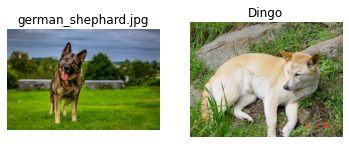

In [26]:
dog_type, prob = predict_dog('german_shephard.jpg')